In [1]:
import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load your trained generator and posterior (already done)
from tensorflow.keras.models import load_model
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

# Load pre-trained SBI posterior (already trained)
# Assume: posterior = inference.build_posterior(density_estimator)

posterior = torch.load("trained_sbi_posterior.pt")


/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_5775/187271608.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("trained_sbi_posterior.

In [2]:
def generate_sbi_training_data(num_simulations=2000, latent_dim=100):
    X, y = [], []

    for _ in range(num_simulations // 2):
        # Generate QPO sample
        fc = np.random.uniform(0.01, 1.0)
        amp = np.random.uniform(0.1, 1.0)
        label_qpo = np.array([[fc, amp, 1.0]], dtype=np.float32)
        z = np.random.randn(1, latent_dim)
        generated_qpo = generator(
            [z, label_qpo], training=False).numpy().squeeze()
        f, Pxx = welch(generated_qpo, fs=1, nperseg=256)
        x = torch.tensor(Pxx, dtype=torch.float32)
        samples = posterior.sample((500,), x=x, show_progress_bars=False)
        X.append([samples[:, 0].mean().item(), samples[:, 1].mean().item()])
        y.append(1)

        # Generate Non-QPO sample
        label_noise = np.array([[fc, amp, 0.0]], dtype=np.float32)
        z = np.random.randn(1, latent_dim)
        generated_noise = generator(
            [z, label_noise], training=False).numpy().squeeze()
        f, Pxx = welch(generated_noise, fs=1, nperseg=256)
        x = torch.tensor(Pxx, dtype=torch.float32)
        samples = posterior.sample((500,), x=x, show_progress_bars=False)
        X.append([samples[:, 0].mean().item(), samples[:, 1].mean().item()])
        y.append(0)

    return np.array(X), np.array(y)

In [3]:
def train_qpo_classifier(X, y):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y)
    return clf

# Run these once
X_train, y_train = generate_sbi_training_data()
clf = train_qpo_classifier(X_train, y_train)


In [4]:
def detect_qpo_from_real_band(curve, posterior, clf):
    f, Pxx = welch(curve.squeeze(), fs=1, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)
    samples = posterior.sample((500,), x=x_obs)
    fc_mean = samples[:, 0].mean().item()
    fc_std = samples[:, 0].std().item()
    amp_mean = samples[:, 1].mean().item()
    qpo_label = clf.predict([[fc_mean, amp_mean]])[0]

    return {
        "fc_model": fc_mean,
        "fc_std": fc_std,
        "amp_model": amp_mean,
        "qpo": bool(qpo_label),
        "samples": samples
    }



🎧 Band 1 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ Mean fc_model: 0.477, Std: 0.247
→ Mean amp: 0.547
→ QPO Detected? ❌ NO


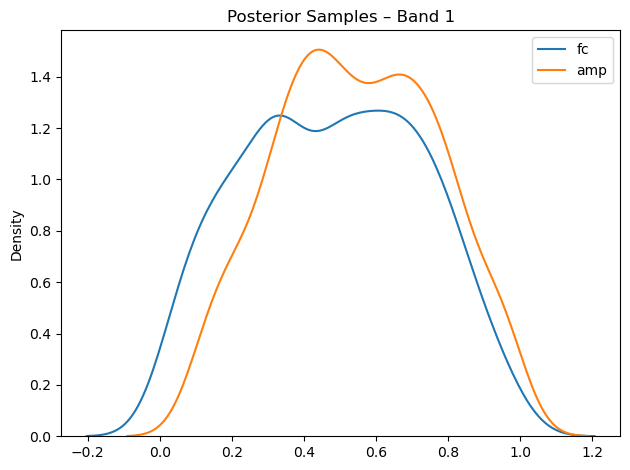


🎧 Band 2 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ Mean fc_model: 0.522, Std: 0.250
→ Mean amp: 0.550
→ QPO Detected? ❌ NO


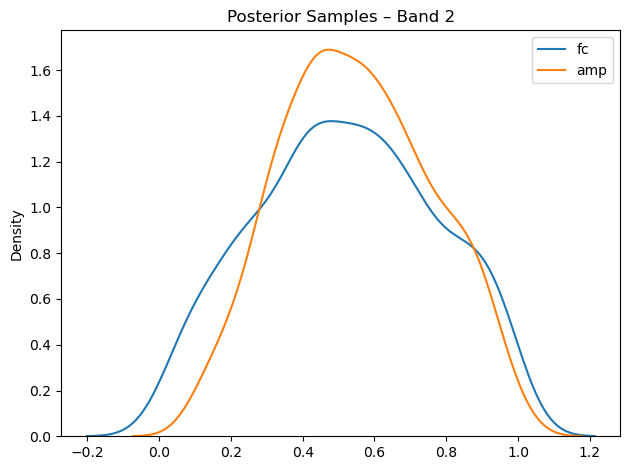


🎧 Band 3 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ Mean fc_model: 0.515, Std: 0.234
→ Mean amp: 0.565
→ QPO Detected? ❌ NO


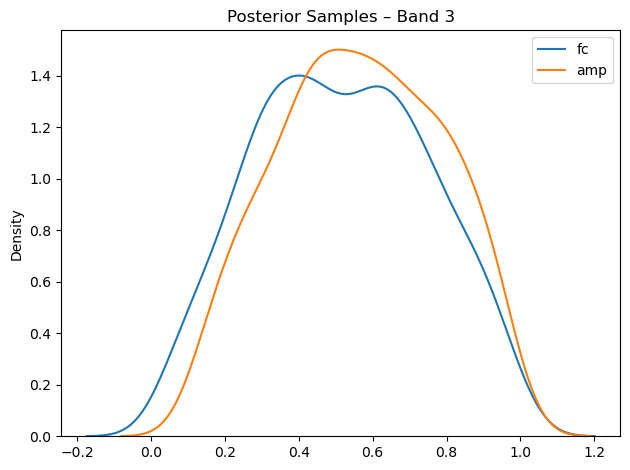


🎧 Band 4 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ Mean fc_model: 0.509, Std: 0.253
→ Mean amp: 0.555
→ QPO Detected? ✅ YES


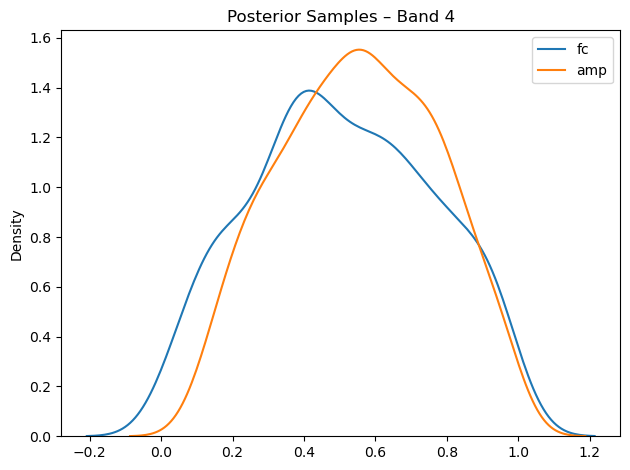

In [5]:
data = np.loadtxt("ltcrv4bands_rej_dt100.dat")
bands = [data[:, i] for i in range(4)]

for i, band in enumerate(bands):
    print(f"\n🎧 Band {i+1} Inference:")
    result = detect_qpo_from_real_band(band, posterior, clf)
    print(f"→ Mean fc_model: {result['fc_model']:.3f}, Std: {result['fc_std']:.3f}")
    print(f"→ Mean amp: {result['amp_model']:.3f}")
    print(f"→ QPO Detected? {'✅ YES' if result['qpo'] else '❌ NO'}")

    # Optional: Plot posterior KDE
    import seaborn as sns
    sns.kdeplot(result['samples'][:, 0].numpy(), label="fc")
    sns.kdeplot(result['samples'][:, 1].numpy(), label="amp")
    plt.title(f"Posterior Samples – Band {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()
